In [3]:
# import dependencies
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
import matplotlib.pyplot as plt

In [4]:
# Load dataset
df = pd.read_csv("crop_recommendation.csv")  

In [5]:
# view first 5 records
df.head()

,N,P,K,temperature,humidity,ph,rainfall,label
0,90,42,43,20.879744,82.002744,6.502985,202.935536,rice
1,85,58,41,21.770462,80.319644,7.038096,226.655537,rice
2,60,55,44,23.004459,82.320763,7.840207,263.964248,rice
3,74,35,40,26.491096,80.158363,6.980401,242.864034,rice
4,78,42,42,20.130175,81.604873,7.628473,262.717340,rice


In [6]:
# Split features and label
X = df.drop("label", axis=1)
y = df["label"]

In [7]:
# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

In [8]:
# Feature scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [9]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

In [10]:
# Store metrics
accuracies = {}
f1_scores = {}
reports = {}
models = {}

In [11]:
# --- ANN ---
def build_ann(input_dim, num_classes):
    model = Sequential()
    model.add(Dense(128, activation="relu", input_dim=input_dim))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(num_classes, activation="softmax"))
    model.compile(optimizer="adam",
                  loss="sparse_categorical_crossentropy",
                  metrics=["accuracy"])
    return model

ann_model = build_ann(X_train.shape[1], len(np.unique(y_encoded)))
ann_model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
ann_preds = np.argmax(ann_model.predict(X_test), axis=1)
ann_acc = accuracy_score(y_test, ann_preds)
ann_f1 = f1_score(y_test, ann_preds, average='weighted')
accuracies["ANN"] = ann_acc
f1_scores["ANN"] = ann_f1
reports["ANN"] = classification_report(y_test, ann_preds, target_names=le.classes_)
models["ANN"] = ann_model

14/14 [==============================] - 0s 1ms/step


In [12]:
# --- Decision Tree ---
dt_model = DecisionTreeClassifier(criterion="entropy", max_depth=10, random_state=42)
dt_model.fit(X_train, y_train)
dt_preds = dt_model.predict(X_test)
dt_acc = accuracy_score(y_test, dt_preds)
dt_f1 = f1_score(y_test, dt_preds, average='weighted')
accuracies["Decision Tree"] = dt_acc
f1_scores["Decision Tree"] = dt_f1
reports["Decision Tree"] = classification_report(y_test, dt_preds, target_names=le.classes_)
models["Decision Tree"] = dt_model

In [13]:
# --- XGBoost ---
xgb_model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)
xgb_acc = accuracy_score(y_test, xgb_preds)
xgb_f1 = f1_score(y_test, xgb_preds, average='weighted')
accuracies["XGBoost"] = xgb_acc
f1_scores["XGBoost"] = xgb_f1
reports["XGBoost"] = classification_report(y_test, xgb_preds, target_names=le.classes_)
models["XGBoost"] = xgb_model

c:\Users\ilhai\Desktop\croprecommendation\venv\lib\site-packages\xgboost\core.py:158: UserWarning: [16:40:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [14]:
# --- Display Results ---
print("\n📊 Model Evaluation Summary:\n")
for model_name in accuracies:
    print(f"{model_name:<15} | Accuracy: {accuracies[model_name]:.2f} | F1-score: {f1_scores[model_name]:.2f}")


📊 Model Evaluation Summary:

ANN             | Accuracy: 0.98 | F1-score: 0.98
Decision Tree   | Accuracy: 0.98 | F1-score: 0.98
XGBoost         | Accuracy: 0.99 | F1-score: 0.99


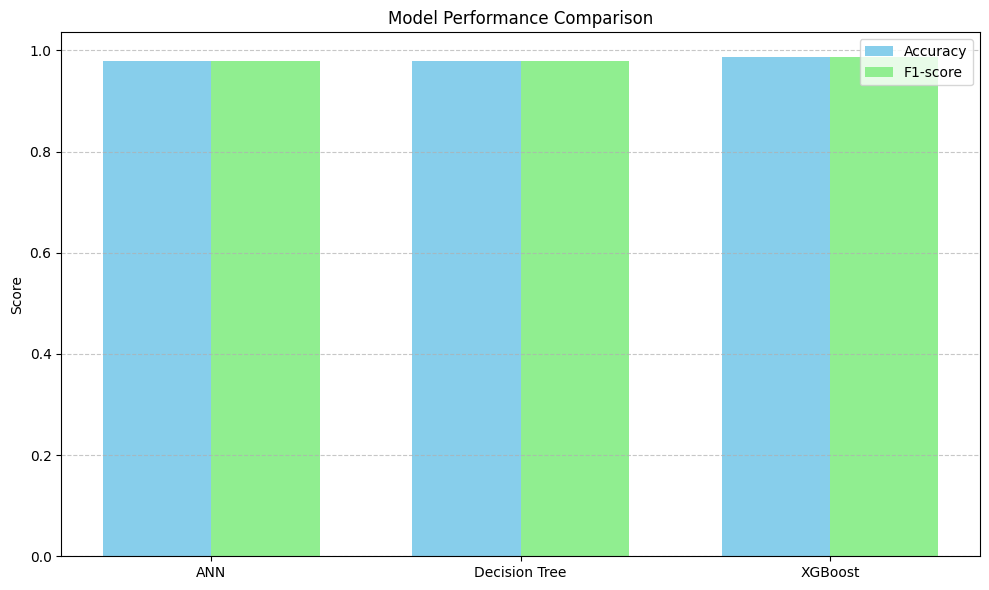

In [15]:
# --- Visual Comparison ---
labels = list(accuracies.keys())
acc_vals = list(accuracies.values())
f1_vals = list(f1_scores.values())

x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(10,6))
plt.bar(x - width/2, acc_vals, width, label='Accuracy', color='skyblue')
plt.bar(x + width/2, f1_vals, width, label='F1-score', color='lightgreen')
plt.xticks(x, labels)
plt.ylabel("Score")
plt.title("Model Performance Comparison")
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [16]:
# --- Save Best Model ---
best_model_name = max(accuracies, key=accuracies.get)
print(f"\n✅ Best Performing Model: {best_model_name} (Accuracy: {accuracies[best_model_name]:.2f})")


✅ Best Performing Model: XGBoost (Accuracy: 0.99)


In [17]:
# Save the model
if best_model_name == "ANN":
    models["ANN"].save("best_model_ann.h5")
else:
    import joblib
    joblib.dump(models[best_model_name], f"best_model_{best_model_name.lower().replace(' ', '_')}.pkl")
    print(f"Model saved as: best_model_{best_model_name.lower().replace(' ', '_')}.pkl")

Model saved as: best_model_xgboost.pkl


In [18]:
# print classification reports
for model_name, report in reports.items():
    print(f"\n📋 Classification Report: {model_name}\n")
    print(report)


📋 Classification Report: ANN

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        23
      banana       1.00      1.00      1.00        21
   blackgram       1.00      0.95      0.97        20
    chickpea       1.00      1.00      1.00        26
     coconut       1.00      1.00      1.00        27
      coffee       0.94      1.00      0.97        17
      cotton       1.00      1.00      1.00        17
      grapes       1.00      1.00      1.00        14
        jute       0.91      0.91      0.91        23
 kidneybeans       0.95      1.00      0.98        20
      lentil       0.73      1.00      0.85        11
       maize       1.00      1.00      1.00        21
       mango       1.00      1.00      1.00        19
   mothbeans       1.00      0.88      0.93        24
    mungbean       1.00      1.00      1.00        19
   muskmelon       1.00      1.00      1.00        17
      orange       1.00      1.00      1.00       